<a href="https://colab.research.google.com/github/sabre-code/flower_classification/blob/main/classification_tfds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers


In [2]:
print(tf.__version__)

2.9.2


In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin = dataset_url, fname = 'flower_photos', untar = True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len((list(data_dir.glob('*/*.jpg'))))
print("Total Images: ",image_count)

Total Images:  3670


In [5]:
rose = list(data_dir.glob('roses/*'))
sunflower = list(data_dir.glob('sunflowers/*'))
tulips = list(data_dir.glob('tulips/*'))
dandelion = list(data_dir.glob('dandelion/*'))
daisy = list(data_dir.glob('daisy/*'))

print("Total Roses :",len(rose))
print("Total Sunflowers :",len(sunflower))
print("Total Tulips :",len(tulips))
print("Total Dandelion :",len(dandelion))
print("Total Daisy :",len(daisy))

Total Roses : 641
Total Sunflowers : 699
Total Tulips : 799
Total Dandelion : 898
Total Daisy : 633


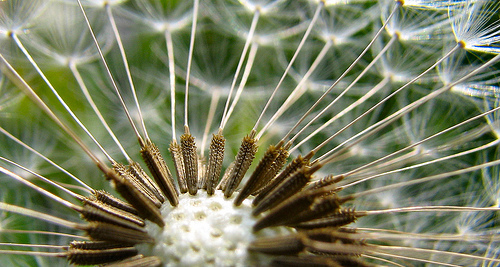

In [6]:
PIL.Image.open(str(dandelion[43]))

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 7,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
tf.random.set_seed(50)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 7,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


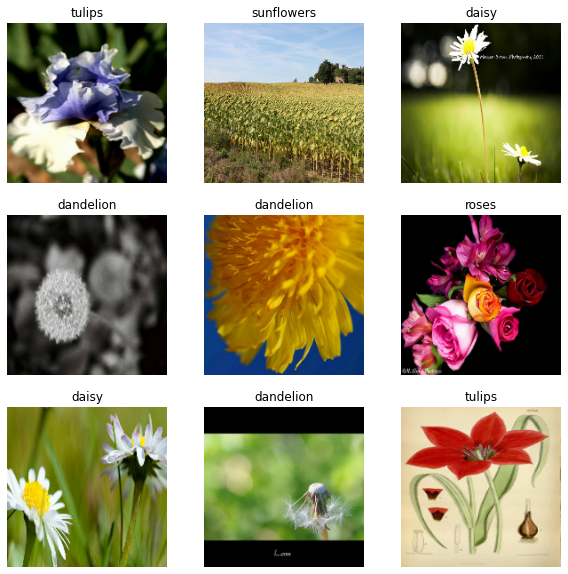

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [13]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


In [14]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [15]:
model.compile(optimizer=Adam(lr = 0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [16]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size = 32,
  epochs=epochs
)


Epoch 1/15
92/92 [==============================] - 19s 57ms/step - loss: 1.2593 - accuracy: 0.4428 - val_loss: 1.1171 - val_accuracy: 0.5777
Epoch 2/15
92/92 [==============================] - 4s 43ms/step - loss: 1.0370 - accuracy: 0.5851 - val_loss: 0.9796 - val_accuracy: 0.6322
Epoch 3/15
92/92 [==============================] - 4s 41ms/step - loss: 0.9339 - accuracy: 0.6339 - val_loss: 0.9249 - val_accuracy: 0.6444
Epoch 4/15
92/92 [==============================] - 4s 42ms/step - loss: 0.8666 - accuracy: 0.6580 - val_loss: 0.8892 - val_accuracy: 0.6567
Epoch 5/15
92/92 [==============================] - 4s 42ms/step - loss: 0.8073 - accuracy: 0.6819 - val_loss: 0.8624 - val_accuracy: 0.6717
Epoch 6/15
92/92 [==============================] - 4s 42ms/step - loss: 0.7713 - accuracy: 0.7119 - val_loss: 0.8299 - val_accuracy: 0.6826
Epoch 7/15
92/92 [==============================] - 4s 42ms/step - loss: 0.7062 - accuracy: 0.7282 - val_loss: 0.8266 - val_accuracy: 0.6935
Epoch 8/15
9

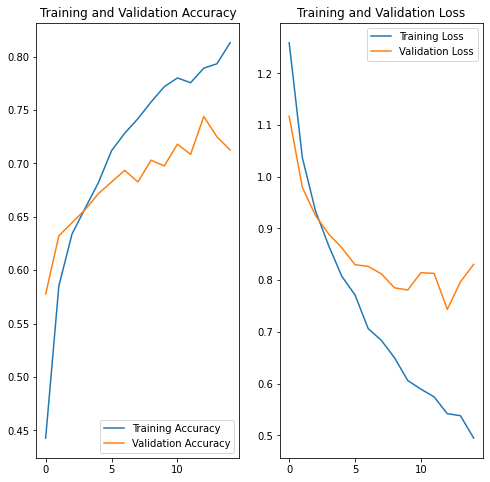

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

